# Mineração de Dados: Agrupamento

**Grupo**:

- Gabriel Oliveira Moreira Faria
- Vinícius Oliveira

**Objetivo**:

Usar algoritmos de agrupamento de dados em vista a agrupar um conjunto de dados referentes a um conjunto de grãos de arroz, que passam por um processo de separação a partir da cadeia produtiva.

Através dos algoritmos de agrupamento, podemos separar os grãos de arroz em grupos, com características distintas para cada categoria, dos quais são separados através de suas características nos algoritmos. A partir disso, podemos fazer uma análise comparativa dos resultados alcançados e dos diferentes parâmetros utilizados para gerar tais resultados, fornecendo uma análise descritiva das características dos grupos encontrados.


Abaixo, segue as características dos grãos que foram extraídas por meio de processamento de imagens:
- area: quantidade de pixels dentro da região do grão;
- perimetro: perímetro do contorno do grão;
- maior-eixo: tamanho do maior eixo que forma o grão;
- menor-eixo: tamanho do menor eixo do grão;
- arredondamento: arredondamento da elipse que forma o grão;
- area-convexa: quantidade de pixels no menor envoltório convexo que cobre o grão; e
- extensao: razão entre a região formada pelo grão e a caixa de corte da imagem do grão.



In [184]:
import itertools as it
import pickle

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pyclustertend
import seaborn as sns
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.cluster import DBSCAN, OPTICS, AgglomerativeClustering, KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import NearestCentroid
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import scale

## Análise exploratória

Primeiro, carregaremos os dados e analisaremos as distribuição das características dos grãos e as correlações entre elas.


In [185]:
df = pd.read_csv("data/trabalho4_dados_4.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1143 entries, 0 to 1142
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   area            1143 non-null   int64  
 1   perimetro       1143 non-null   float64
 2   maior-eixo      1143 non-null   float64
 3   menor-eixo      1143 non-null   float64
 4   arredondamento  1143 non-null   float64
 5   area-convexa    1143 non-null   int64  
 6   extensao        1143 non-null   float64
dtypes: float64(5), int64(2)
memory usage: 62.6 KB


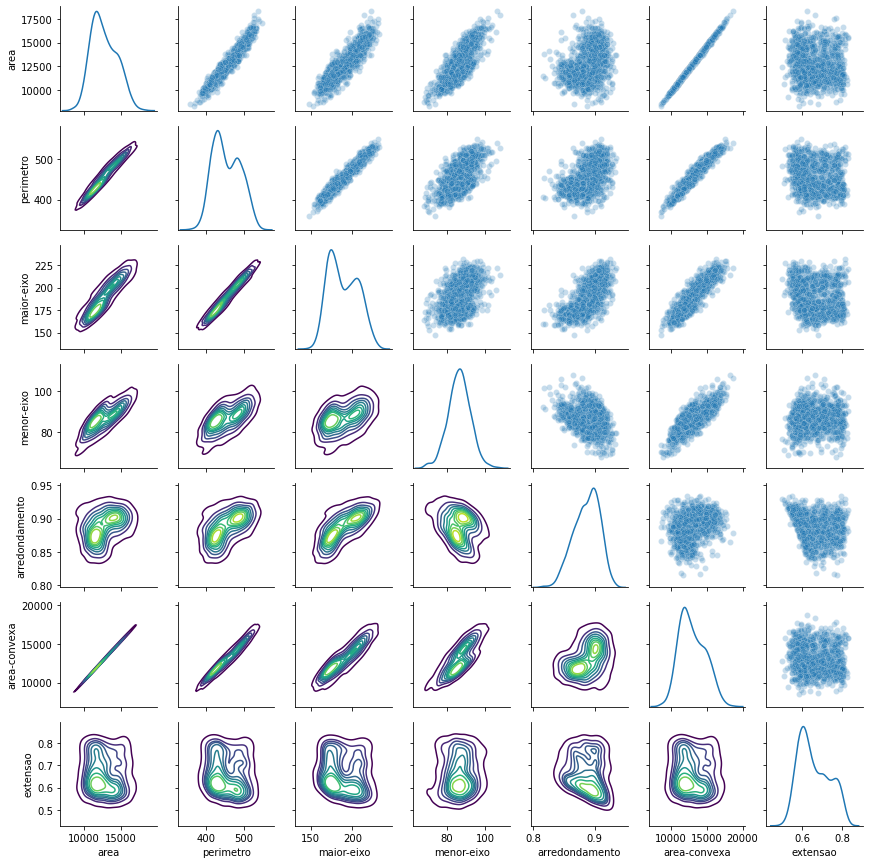

In [186]:
# Distribuição
g = sns.PairGrid(df, diag_sharey=False, height=1.75)
g.map_upper(sns.scatterplot, alpha=0.25)
g.map_lower(sns.kdeplot, cmap="viridis")
g.map_diag(sns.kdeplot)

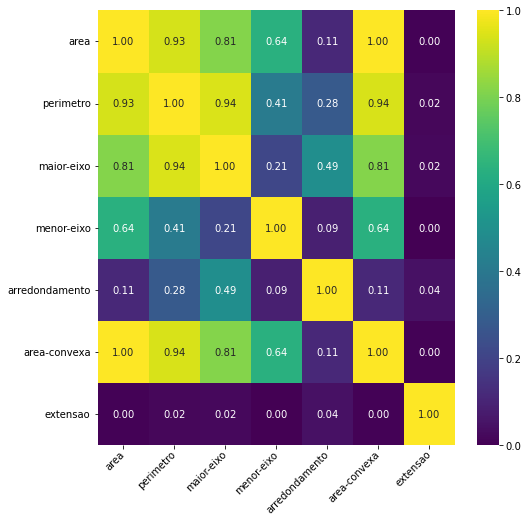

In [187]:
# Correlação linear (R^2)
plt.figure(figsize=(8, 8))
corr = df.corr()
g = sns.heatmap(corr ** 2, annot=True, vmin=0, vmax=1, fmt=".2f", cmap="viridis")
g.set_xticklabels(
    g.get_xticklabels(), rotation=45, va="center", ha="right", rotation_mode="anchor"
);

O primeiro gráfico revela duas informações interessantes:

- Em diversas das projeções, inclusive as unidimensionais, existem um ou dois picos de densidade bem definidos. Os dados projetados são facilmente separados em dois grupos. Visualmente, várias distribuições aparentam poder ser aproximadas por uma ou duas distribuições normais.
- Algumas das características são fortemente correlacionadas (linearmente). Nesse caso, as características são redundantes para a tarefa de agrupamento e podemos remover algumas delas.
  - O segundo gráfico exibe as correlações lineares através do índice $R^2$.


## Tendência de agrupamento

A seguir, verificaremos a aleatoriedade espacial dos dados através da estatística de Hopkins para diferentes configurações de características (100 vezes cada). Mas, antes, padronizaremos os dados.


In [188]:
# Padronizar os dados
X = pd.DataFrame()
X[df.columns] = scale(df[df.columns])
X.describe()

area     perimetro    maior-eixo    menor-eixo  arredondamento  \
count  1.143000e+03  1.143000e+03  1.143000e+03  1.143000e+03    1.143000e+03   
mean  -3.590013e-16  1.272240e-15  1.225811e-16  6.478729e-16    3.847025e-15   
std    1.000438e+00  1.000438e+00  1.000438e+00  1.000438e+00    1.000438e+00   
min   -2.509628e+00 -2.693842e+00 -2.380168e+00 -3.183893e+00   -3.452512e+00   
25%   -7.619569e-01 -7.912156e-01 -8.540997e-01 -6.369296e-01   -7.025409e-01   
50%   -1.415949e-01 -1.476076e-01 -1.628963e-01  1.628585e-02    1.245985e-01   
75%    7.434967e-01  8.031325e-01  8.563650e-01  6.295541e-01    7.648869e-01   
max    3.181061e+00  2.603008e+00  2.439498e+00  3.583633e+00    2.293564e+00   

       area-convexa      extensao  
count  1.143000e+03  1.143000e+03  
mean   2.121371e-16 -1.798892e-16  
std    1.000438e+00  1.000438e+00  
min   -2.465338e+00 -2.121627e+00  
25%   -7.709632e-01 -8.121555e-01  
50%   -1.280779e-01 -2.334658e-01  
75%    7.596369e-01  7.760474e-01  
max    3.166848e+00  2.215740e+00

In [189]:
column_combinations = [
    list(cols)
    for n_cols in range(2, len(X.columns) + 1)
    for cols in it.combinations(X.columns, n_cols)
]

In [190]:
H_SCORES_PATH = "data/h_scores.pkl"
try:
    with open(H_SCORES_PATH, "rb") as file:
        h_scores = pickle.load(file)
except FileNotFoundError:
    result = dict(cols=[], score=[])
    for cols in column_combinations:
        X_proj = X[list(cols)]
        for _ in range(100):
            result["cols"].append(frozenset(cols))
            result["score"].append(
                pyclustertend.hopkins(X_proj, sampling_size=len(X_proj))
            )
    result = pd.DataFrame(result)
    h_scores = pd.DataFrame()
    h_scores["mean"] = result.groupby("cols")["score"].mean()
    h_scores["std"] = result.groupby("cols")["score"].std()
    with open(H_SCORES_PATH, "wb") as file:
        pickle.dump(h_scores, file)

In [191]:
print("Projeções com H<0.5:", (h_scores["mean"] < 0.5).sum())
h_scores.sort_values(by="mean", ascending=True).head(n=5)

Projeções com H<0.5: 120


mean       std
cols                                               
(area-convexa, area)             0.011505  0.000236
(area-convexa, perimetro, area)  0.028419  0.000383
(area-convexa, perimetro)        0.034838  0.000896
(area, perimetro)                0.036361  0.001122
(perimetro, maior-eixo)          0.038670  0.000978

A tabela acima mostra que as cinco melhores projeções de acordo com a estatística de Hopkins contêm apenas um topo na distribuição dos pontos (exceto, possivelmente, o último caso). Ao usar uma dessas projeções, a tendência é que haja um grupo principal e um grupo de 'outliers'. Isso porque a estatística de Hopkins testa apenas a uniformidade dos dados. A estatística sozinha não é apropriada para selecionar a melhor projeção.

Portanto, não faremos nenhum pré-processamento baseado nos melhores resultados de $H$. Escolheremos a combinação ótima das características na etapa a seguir.

## Algoritmos de agrupamento e otimização de parâmetros

Agora, analisaremos o desempenho de alguns algoritmos de agrupamento em diferentes configurações de características e parâmetros de modelo. Para isso, faremos uma busca em grade usando o _coeficiente da silhueta_ (usando a dissimilaridade do cosseno como distância) como critério de otimização.

A busca otimizará simultaneamente o algoritmo, seus parâmetros e as características de entrada. Cada configuração será testada 5 vezes.

> 1*: a dissimilaridade do cosseno foi escolhida com base em experimentos.
> 2: aqui, poderíamos limitar o espaço de busca de projeções de características usando os valores da estatística de Hopkins calculados na etapa anterior. Poderíamos também usar os valores de $R^2$ calculados na primeira etapa.

In [192]:
class ColumnSelector(BaseEstimator, TransformerMixin):
    def __init__(self, columns=None):
        self.columns = columns

    def fit(self, X, y=None):
        pass

    def transform(self, X, y=None):
        if self.columns is not None:
            X = X[self.columns]
        return X

    def fit_transform(self, X, y=None):
        return self.transform(X, y)


def score_wrapper(pipe, X_test):
    estimator = pipe[-1]
    y = estimator.labels_
    if len(np.unique(y)) == 1:
        return -1
    return silhouette_score(X, y, metric="cosine")

In [193]:
SEARCH_RESULTS_PATH = "data/search_results.pkl"
try:
    with open(SEARCH_RESULTS_PATH, "rb") as file:
        search_results = pickle.load(file)
except FileNotFoundError:
    pipe = pipe = Pipeline(
        [
            ("select", ColumnSelector()),
            ("estimator", KMeans()),  # dummy
        ]
    )
    search = GridSearchCV(
        pipe,
        param_grid=[
            {
                "select__columns": column_combinations,
                "estimator": [KMeans()],
                "estimator__n_clusters": [2, 3, 4, 5, 7, 10],
            },
            {
                "select__columns": column_combinations,
                "estimator": [AgglomerativeClustering()],
                "estimator__n_clusters": [2, 3, 4, 5, 7, 10],
                "estimator__linkage": ["ward", "complete", "average", "single"],
            },
            {
                "select__columns": column_combinations,
                "estimator": [DBSCAN()],
                "estimator__eps": [0.1, 0.25, 0.5, 0.75, 1.0, 2.0],
                "estimator__min_samples": [2, 3, 4, 5, 10, 20],
                "estimator__p": [1, 2],
            },
            {
                "select__columns": column_combinations,
                "estimator": [OPTICS()],
                "estimator__min_samples": [2, 3, 4, 5, 10, 20],
                "estimator__p": [1, 2],
            },
        ],
        scoring=score_wrapper,
        # Os dados DEVEM ser testados no conjunto de treino
        cv=[(list(range(len(X))), list(range(len(X))))] * 5,
        n_jobs=-1,
    )
    _ = search.fit(X)
    search_results = pd.DataFrame(search.cv_results_).sort_values(
        by="mean_test_score", ascending=False
    )
    with open(SEARCH_RESULTS_PATH, "wb") as file:
        pickle.dump(search_results, file)

In [194]:
best_result = search_results["params"][search_results.index[0]].copy()
best_result["select__columns"] = [best_result["select__columns"]]
pd.DataFrame(best_result)

estimator  estimator__n_clusters  \
0  KMeans(n_clusters=2)                      2   

                                     select__columns  
0  [area, perimetro, maior-eixo, menor-eixo, arre...

## Resultados

Analisemos agora os resultados. Primeiro, examinaremos o processo de busca de parâmetros. Depois, estudaremos os detalhes do agrupamento em si.


param_estimator  mean_test_score  std_test_score  \
113         KMeans(n_clusters=2)         0.643287        0.000227   
2181   AgglomerativeClustering()         0.642958        0.000000   
6407                    DBSCAN()         0.188947        0.000000   
13678                   OPTICS()         0.005924        0.000000   

                                   param_select__columns  rank_test_score  
113    [area, perimetro, maior-eixo, menor-eixo, arre...                1  
2181                       [area, perimetro, maior-eixo]                3  
6407              [maior-eixo, menor-eixo, area-convexa]             1316  
13678  [perimetro, maior-eixo, menor-eixo, arredondam...             2368

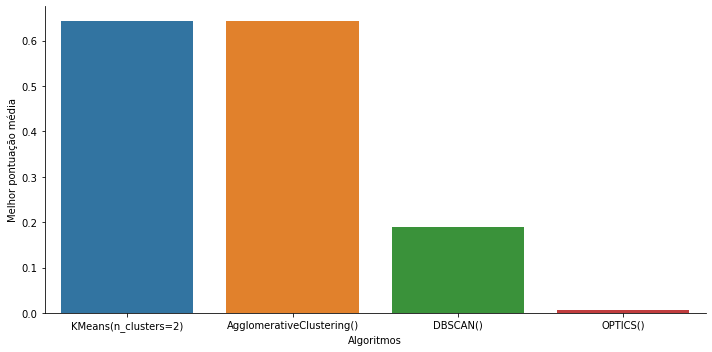

In [195]:
key = lambda x: str(search_results.loc[x, "param_estimator"])
group = search_results.groupby(key)
idx = group["mean_test_score"].transform(max) == search_results["mean_test_score"]
models_results = (
    search_results[idx]
    .sort_values("std_test_score")
    .sort_values("mean_test_score", ascending=False)
    .drop_duplicates("param_estimator")
)
models_results["model"] = models_results["param_estimator"].map(str)

g = sns.catplot(
    data=models_results,
    x="model",
    y="mean_test_score",
    kind="bar",
    aspect=2,
)
g.ax.set_xlabel("Algoritmos")
g.ax.set_ylabel("Melhor pontuação média")

models_results[
    [
        "param_estimator",
        "mean_test_score",
        "std_test_score",
        "param_select__columns",
        "rank_test_score",
    ]
]

In [196]:
for p in models_results["params"]:
    for k, v in p.items():
        print("\t" if k != "estimator" else "", k, ": ", v, sep="")

estimator: KMeans(n_clusters=2)
	estimator__n_clusters: 2
	select__columns: ['area', 'perimetro', 'maior-eixo', 'menor-eixo', 'arredondamento', 'extensao']
estimator: AgglomerativeClustering()
	estimator__linkage: average
	estimator__n_clusters: 2
	select__columns: ['area', 'perimetro', 'maior-eixo']
estimator: DBSCAN()
	estimator__eps: 0.25
	estimator__min_samples: 20
	estimator__p: 2
	select__columns: ['maior-eixo', 'menor-eixo', 'area-convexa']
estimator: OPTICS()
	estimator__min_samples: 20
	estimator__p: 2
	select__columns: ['perimetro', 'maior-eixo', 'menor-eixo', 'arredondamento', 'area-convexa', 'extensao']


O gráfico acima mostra que o algoritmo KMeans, com determinado conjunto de parâmetros e características, obteve o melhor resultado de acordo com o coeficiente da silhueta.

Antes de continuarmos a análise dos algoritmos, vamos estudar a sensibilidade da qualidade dos resultados com relação à escolha das características.


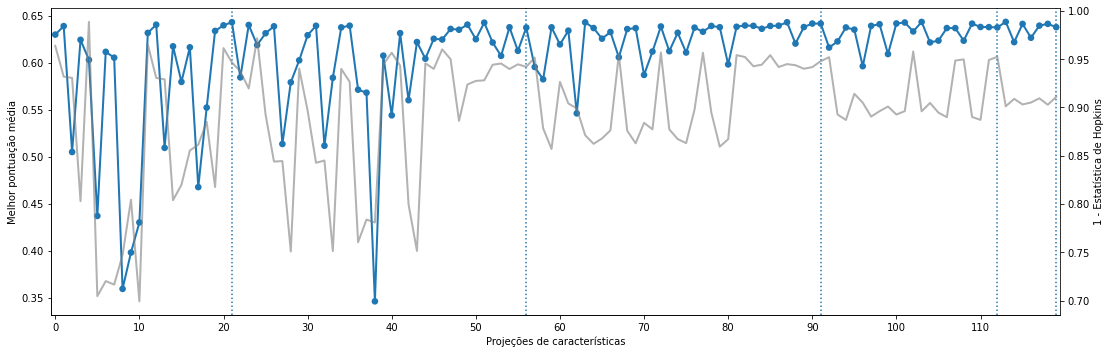

In [197]:
# Ordenar caractrerísticas de forma que elementos adjacentes
# estejam a uma modificação de distância
indices = [frozenset(column_combinations[0])]
curr_len = min(len(cols) for cols in column_combinations)
while len(indices) < len(column_combinations):
    n_appended = 0
    for cols in column_combinations:
        cols = frozenset(cols)
        last = indices[-1]
        if len(cols) != curr_len or cols in indices:
            continue
        if cols > last:
            distance = len(cols - last)
        else:
            distance = len(last - cols)
        if distance == 1:
            indices.append(cols)
            n_appended += 1
    if n_appended == 0:
        curr_len += 1

# Performance score
key = lambda x: frozenset(search_results.loc[x, "param_select__columns"])
group = search_results.groupby(key)

plt_data = pd.DataFrame(group["mean_test_score"].max())
kk = plt_data.copy()
plt_data = plt_data.reindex(indices)
plt_data["index"] = list(range(len(plt_data)))
plt_data["n_features"] = plt_data.index.map(len)

g = sns.catplot(
    data=plt_data,
    x="index",
    y="mean_test_score",
    kind="point",
    aspect=3,
    scale=0.75,
)
g.ax.set_xlabel("Projeções de características")
g.ax.set_ylabel("Melhor pontuação média")
for i, (x1, x2) in enumerate(zip(plt_data["n_features"], plt_data["n_features"][1:])):
    if x1 != x2:
        g.ax.axvline(x=i + 1, ls=":")

# H-score
plt_data = h_scores.reindex(plt_data.index)
ax2 = g.ax.twinx()
sns.pointplot(
    x=list(range(len(plt_data))),
    y=1 - plt_data["mean"],
    ax=ax2,
    color="grey",
    scale=0.75,
)
ax2.set_ylabel("1 - Estatística de Hopkins")
ax2.set_xticks(list(range(0, len(plt_data), 10)))
plt.setp(ax2.collections, alpha=0)
plt.setp(ax2.lines, alpha=0.6);

O gráfico acima possui uma propriedade especial: da esquerda para a direita, o número de características é crescente e entre quaisquer duas projeções adjacentes, o conjunto de características difere em exatamente uma coluna. Com isso, é possível observar tanto a sensibilidade global, quanto a sensibilidade a pequenas mudanças.

Podemos fazer as seguintes observações:

- A qualidade do agrupamento se altera significativamente com a mudança das características, especialmente quando o número de características é pequeno.
- A estatística de Hopkins é significativamente correlacionada com o coeficiente de silhueta, apesar de não ser capaz de prever a melhor configuração.

> Em um cenário mais complexo, poderíamos fazer uma busca de parâmetros iterativa, diminuindo o limiar de $H$ a cada iteração.


## Abaixo foi feito um agrupamento dos procedimentos usando o algoritmo DBSCAN

- Diferença de densidade que ele tem nas bordas, 

In [198]:
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import MinMaxScaler

def dbscan_clustering(df, columns, scaling=False, eps=0.5, min_samples=5, p=None):

    # Select data and make scaling of them
    K = df[columns].values
    if(scaling):
        scaler = MinMaxScaler(feature_range=(0, 1))
        K = scaler.fit_transform(K)

    #  Compute DBSCAN
    db = DBSCAN(eps=eps, min_samples=min_samples, n_jobs=-1, p=p).fit(K)
    core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
    core_samples_mask[db.core_sample_indices_] = True
    labels = db.labels_

    # Number of clusters in labels, ignoring noise if present.
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)




    # #############################################################################
    # Plot result

    # Black removed and is used for noise/outlier instead.
    unique_labels = set(labels)
    colors = [plt.cm.Spectral(each)
            for each in np.linspace(0, 1, len(unique_labels))]

    fig = plt.figure()
    fig = plt.figure(figsize=(11., 11.))
    ax = fig.add_subplot(111, projection='3d', title='dbscan')

    for k, col in zip(unique_labels, colors):
        if k == -1:
            # Black used for noise.
            col = [0, 0, 0, 1]

        class_member_mask = (labels == k)

        xy = K[class_member_mask & core_samples_mask]
        ax.scatter(xy[:, 2], xy[:, 1], xy[:, 0], color=tuple(col), alpha=0.8, edgecolor='k', marker='o', s=200, label = k)
        
        #plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),markeredgecolor='k', markersize=14)

        xy = K[class_member_mask & ~core_samples_mask]
        ax.scatter(xy[:, 2], xy[:, 1], xy[:, 0], color=tuple(col), alpha=0.8,edgecolor='k', marker='o', s=60)


    ax.set_title('Agrupamento não supervisionado DBSCAN - Agrupamentos (clusters): %d' % n_clusters_)
    ax.set_xlabel(columns[2])
    ax.set_ylabel(columns[1])
    ax.set_zlabel(columns[0])
    plt.legend(loc = 'best')
    plt.show()

    pd.options.display.float_format = "{:.2f}".format


    # Impressão dos clusters
    clusters = [ K[labels == i] for i in range(n_clusters_) ]
    outliers = K[labels == -1]

    for j in range(n_clusters_):
        if(scaling):
            cluster = scaler.inverse_transform(clusters[j])
        else:
            cluster = clusters[j]
        cluster = pd.DataFrame(clusters[j], columns=columns)
        print('----------------------------------------------')
        print('Grupo', j, 'com', len(cluster), 'procedimentos')
        print(cluster.describe().round(2))

<Figure size 432x288 with 0 Axes>

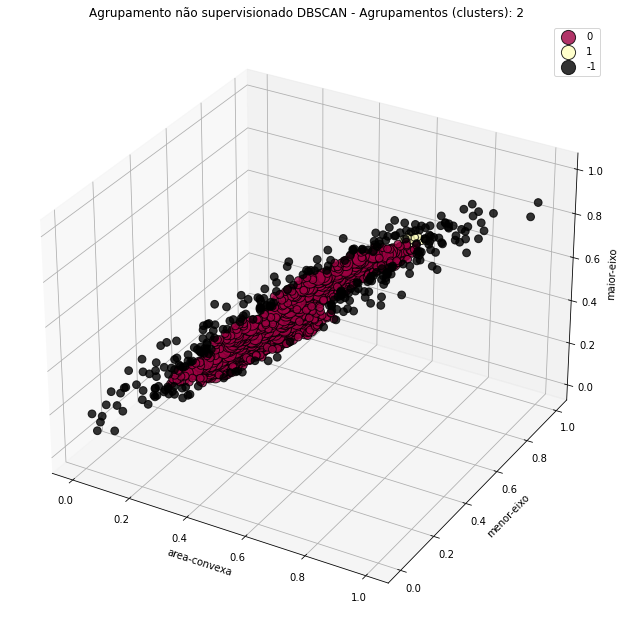

----------------------------------------------
Grupo 0 com 849 procedimentos
       maior-eixo  menor-eixo  area-convexa
count      849.00      849.00        849.00
mean         0.46        0.47          0.42
std          0.18        0.10          0.14
min          0.15        0.22          0.15
25%          0.31        0.40          0.31
50%          0.42        0.47          0.39
75%          0.64        0.54          0.52
max          0.83        0.70          0.74
----------------------------------------------
Grupo 1 com 15 procedimentos
       maior-eixo  menor-eixo  area-convexa
count       15.00       15.00         15.00
mean         0.83        0.65          0.75
std          0.02        0.02          0.01
min          0.80        0.62          0.73
25%          0.82        0.63          0.74
50%          0.83        0.64          0.74
75%          0.85        0.67          0.76
max          0.86        0.68          0.78


In [199]:
dbscan_clustering(df, ['maior-eixo', 'menor-eixo', 'area-convexa'], True, eps=0.05, min_samples=20, p=2)

<Figure size 432x288 with 0 Axes>

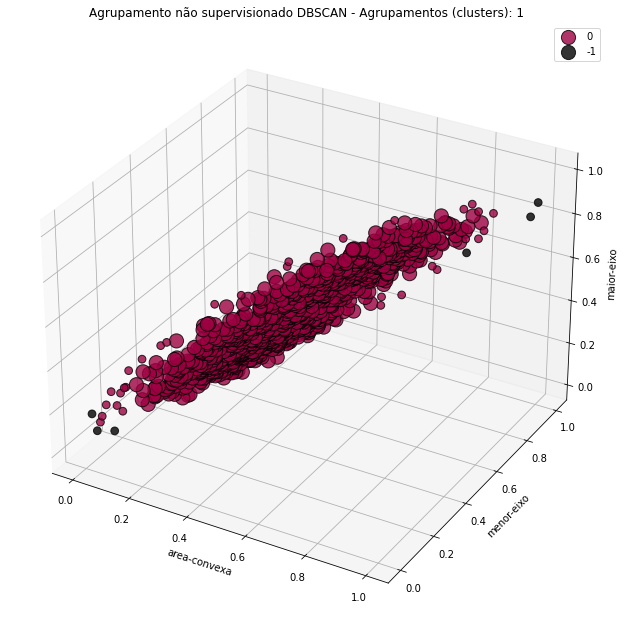

----------------------------------------------
Grupo 0 com 1137 procedimentos
       maior-eixo  menor-eixo  area-convexa
count     1137.00     1137.00       1137.00
mean         0.49        0.47          0.44
std          0.21        0.14          0.17
min          0.08        0.02          0.02
25%          0.32        0.38          0.30
50%          0.46        0.47          0.41
75%          0.67        0.56          0.57
max          1.00        0.91          0.91


In [200]:
dbscan_clustering(df, ['maior-eixo', 'menor-eixo', 'area-convexa'], True, eps=0.15, min_samples=20, p=2)

<Figure size 432x288 with 0 Axes>

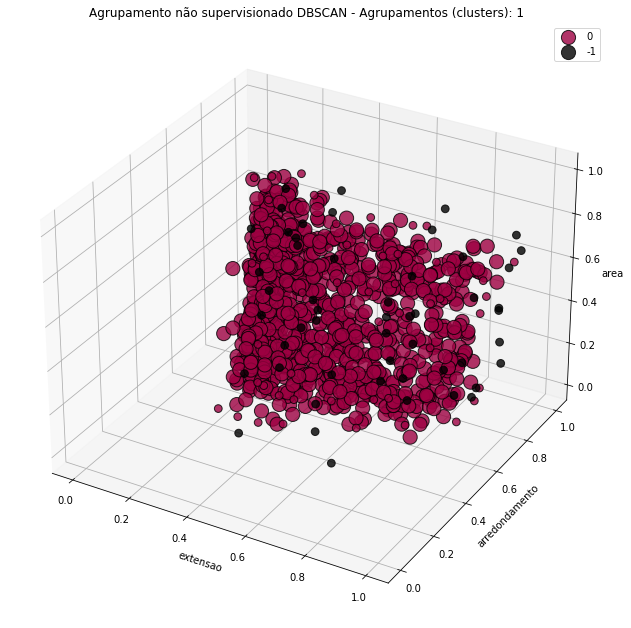

----------------------------------------------
Grupo 0 com 1091 procedimentos
         area  arredondamento  extensao
count 1091.00         1091.00   1091.00
mean     0.44            0.60      0.48
std      0.17            0.17      0.23
min      0.00            0.12      0.04
25%      0.31            0.48      0.30
50%      0.41            0.62      0.42
75%      0.57            0.72      0.66
max      0.89            0.95      1.00


In [201]:
dbscan_clustering(df, ['area','arredondamento','extensao'], True, 0.1)

<Figure size 432x288 with 0 Axes>

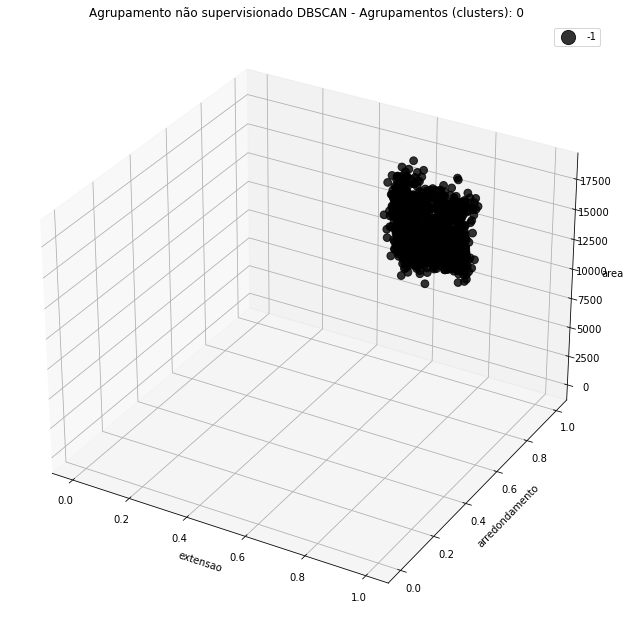

In [202]:
dbscan_clustering(df, ['area','arredondamento','extensao', 'perimetro', 'area-convexa', 'maior-eixo', 'menor-eixo'])

<Figure size 432x288 with 0 Axes>

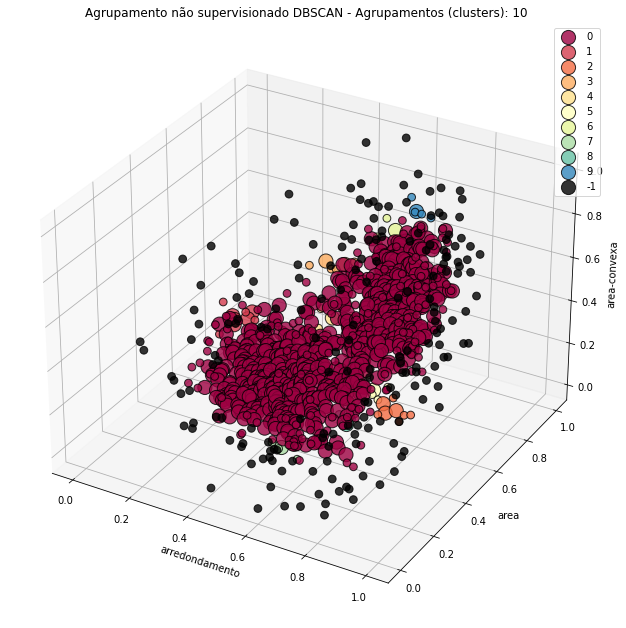

----------------------------------------------
Grupo 0 com 894 procedimentos
       area-convexa   area  arredondamento  extensao  perimetro  maior-eixo  \
count        894.00 894.00          894.00    894.00     894.00      894.00   
mean           0.43   0.43            0.59      0.46       0.50        0.48   
std            0.16   0.15            0.15      0.22       0.17        0.19   
min            0.13   0.15            0.20      0.08       0.20        0.15   
25%            0.30   0.31            0.47      0.29       0.36        0.31   
50%            0.40   0.41            0.61      0.40       0.47        0.44   
75%            0.56   0.56            0.71      0.63       0.65        0.66   
max            0.80   0.80            0.90      0.99       0.92        0.90   

       menor-eixo  
count      894.00  
mean         0.47  
std          0.11  
min          0.11  
25%          0.40  
50%          0.47  
75%          0.55  
max          0.77  
-------------------------------

In [203]:
dbscan_clustering(df, ['area-convexa', 'area','arredondamento','extensao', 'perimetro', 'maior-eixo', 'menor-eixo'], True, eps=0.1)

### Agrupamento

Analisemos agora o agrupamento de cada algoritmo em divsersas projeções do conjunto de dados, incluindo uma PCA.


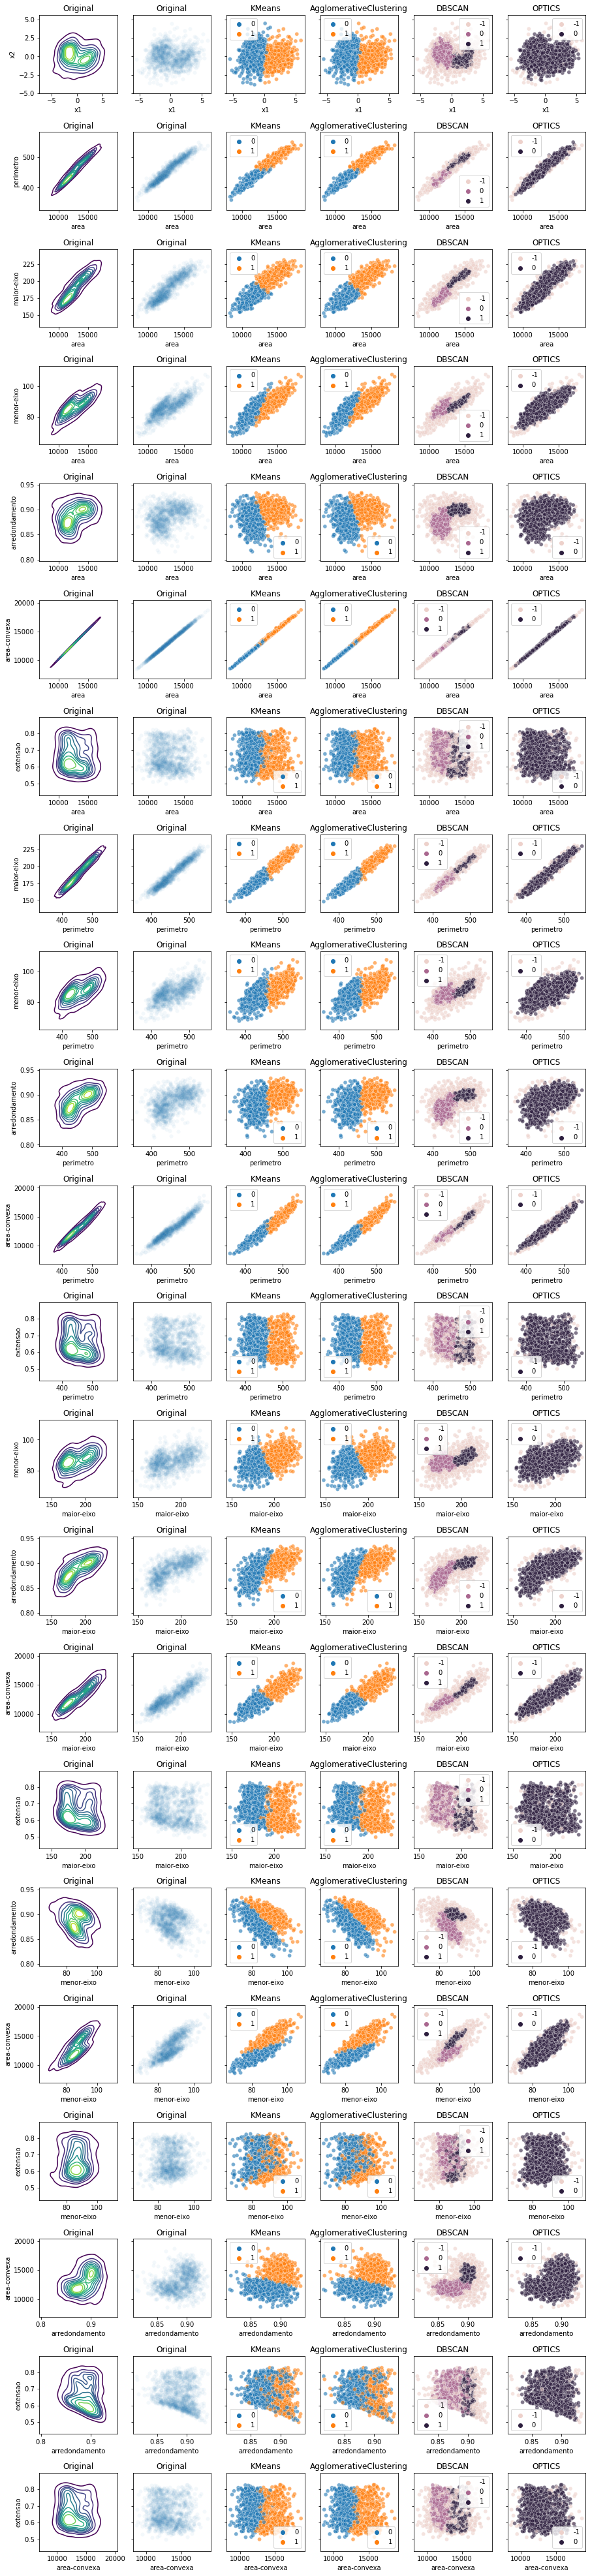

In [204]:
def make_estimator(params):
    pipe = Pipeline(
        [
            ("select", ColumnSelector()),
            ("estimator", KMeans()),  # dummy
        ]
    )
    pipe.set_params(**params)
    return pipe


estimators = models_results["params"].map(make_estimator)
predictions = [estimator.fit_predict(X) for estimator in estimators]

pca_projection = PCA(n_components=2).fit_transform(X)
pca_projection = pd.DataFrame(pca_projection, columns=["x1", "x2"])
projections = [
    pca_projection,
    *[df[list(cols)] for cols in it.combinations(X.columns, 2)],
]

fig, ax = plt.subplots(
    nrows=len(projections),
    ncols=len(models_results) + 2,
    sharey="row",
    figsize=(15, 3.25 * len(projections)),
)
plt.subplots_adjust(hspace=0.5)
for j, data in enumerate(projections):
    g = sns.kdeplot(
        data=data, x=data.columns[0], y=data.columns[1], cmap="viridis", ax=ax[j, 0]
    )
    ax[j, 0].set_title("Original")
    g = sns.scatterplot(
        data=data,
        x=data.columns[0],
        y=data.columns[1],
        cmap="viridis",
        ax=ax[j, 1],
        alpha=0.05,
    )
    ax[j, 1].set_title("Original")
    for i, (estimator, y_pred) in enumerate(zip(estimators, predictions)):
        g = sns.scatterplot(
            data=data,
            x=data.columns[0],
            y=data.columns[1],
            hue=y_pred,
            alpha=0.6,
            ax=ax[j, i + 2],
        )
        g.set_title(str(estimator["estimator"]).split("(")[0])

O KMeans e o AgglomerativeClustering geraram agrupamentos semelhantes, que em geral são capazes de dividir os dados entre os dois picos de densidades das várias projeções. O DBSCAN conseguiu o mesmo, porém considerando os dados em regiões de baixa densidade como outliers*. O OPTICS agrupou os dados em elementos centrais e não-centrais.

O porquê de o comportamento do OPTICS e do DBSCAN ter sido diferente, bem como a influência da dissimilaridade do cosseno no processo de otimização são deixadas para estudos futuros.

Agora, vamos caracterizar os dados baseando-nos nos centros dos grupos gerados pelo KMeans.

> 1*: Esse comportamento só emergiu na otimização do coeficiente da silhueta com dissimilaridade do cosseno. Os agrupamentos para a otimização com distância euclidiana estão contidos na pasta `data`.

### Caracterização


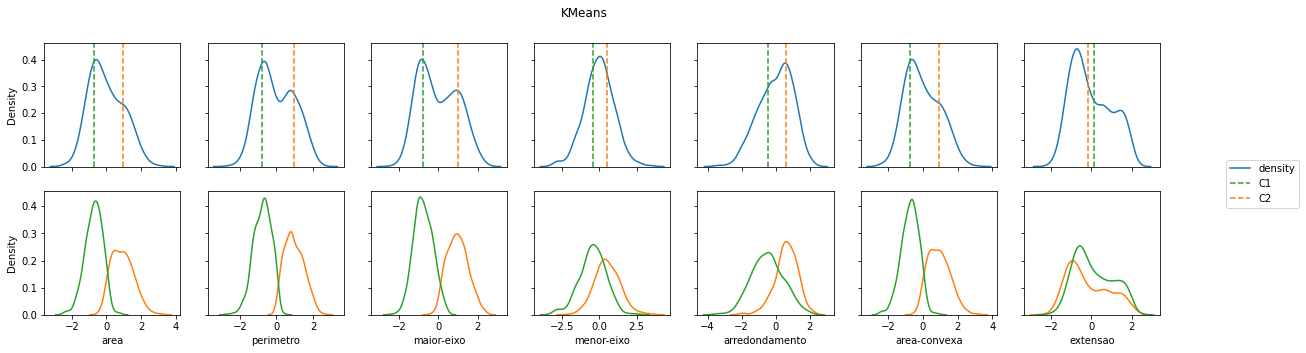

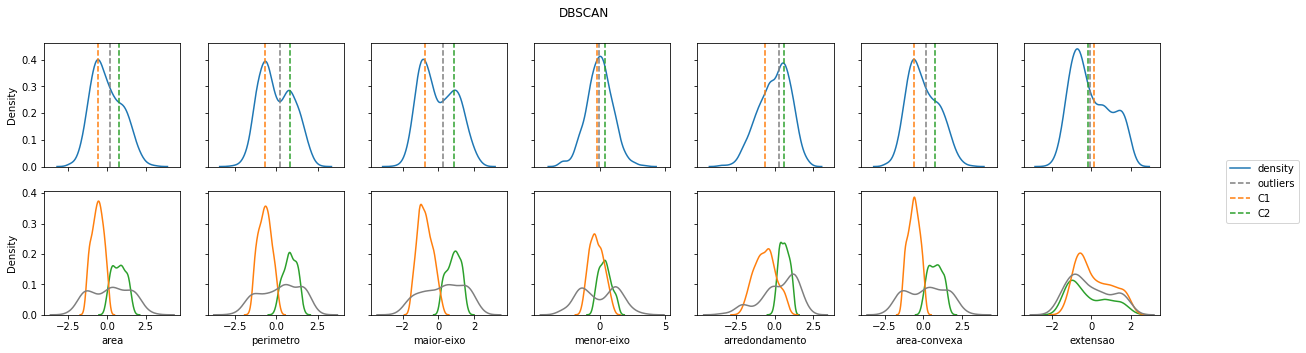

In [205]:
# KMeans
model = next(estimator for estimator in estimators if "KMeans" in str(estimator))[-1]
centroids = NearestCentroid().fit(X, model.labels_).centroids_

fig, ax = plt.subplots(
    nrows=2,
    ncols=len(df.columns),
    sharey="row",
    sharex="col",
    figsize=(20, 5),
)

ignore = []
colors = ["tab:green", "tab:orange", "tab:purple"]
for i, col in enumerate(X.columns):
    g = sns.kdeplot(data=X, x=col, ax=ax[0, i], color="tab:blue")
    if col in ignore:
        g.set_title(f"ignorar")
    for k, c in enumerate(centroids):
        g.axvline(x=c[i], linestyle="--", color=colors[k])
fig.legend(
    ["density"] + [f"C{k+1}" for k in range(len(centroids))],
    bbox_to_anchor=(1, 0.57),
)

for i, col in enumerate(X.columns):
    g = sns.kdeplot(
        data=X,
        x=col,
        ax=ax[1, i],
        hue=model.labels_,
        palette=colors[: len(centroids)],
        legend=None,
    )
fig.suptitle("KMeans");

# DBSCAN
model = next(estimator for estimator in estimators if "DBSCAN" in str(estimator))[-1]
centroids = NearestCentroid().fit(X, model.labels_).centroids_

fig, ax = plt.subplots(
    nrows=2,
    ncols=len(X.columns),
    sharey="row",
    sharex="col",
    figsize=(20, 5),
)

ignore = []
colors = ["tab:gray", "tab:orange", "tab:green"]
for i, col in enumerate(X.columns):
    g = sns.kdeplot(data=X, x=col, ax=ax[0, i], color="tab:blue")
    if col in ignore:
        g.set_title(f"ignorar")
    for k, c in enumerate(centroids):
        g.axvline(x=c[i], linestyle="--", color=colors[k])
fig.legend(
    ["density"] + [f"C{k}" if k > 0 else "outliers" for k in range(len(centroids))],
    bbox_to_anchor=(1, 0.57),
)

for i, col in enumerate(X.columns):
    g = sns.kdeplot(
        data=X,
        x=col,
        ax=ax[1, i],
        hue=model.labels_,
        palette=colors[: len(centroids)],
        legend=None,
    )
fig.suptitle("DBSCAN");

Observa-se que a distribuição da "extensão" não é muito diferente entre os dois grupos, apesar de ela poder ser aproximada pela soma de duas distribuições normais diferentes. Poderíamos criar um KMeans de dois grupos nesse eixo e cruzá-los com os grupos já existentes, criando 4 grupos no total.

> Baseado nas distribuições das características, poderíamos testar a significância estatística da diferença entre os grupos.

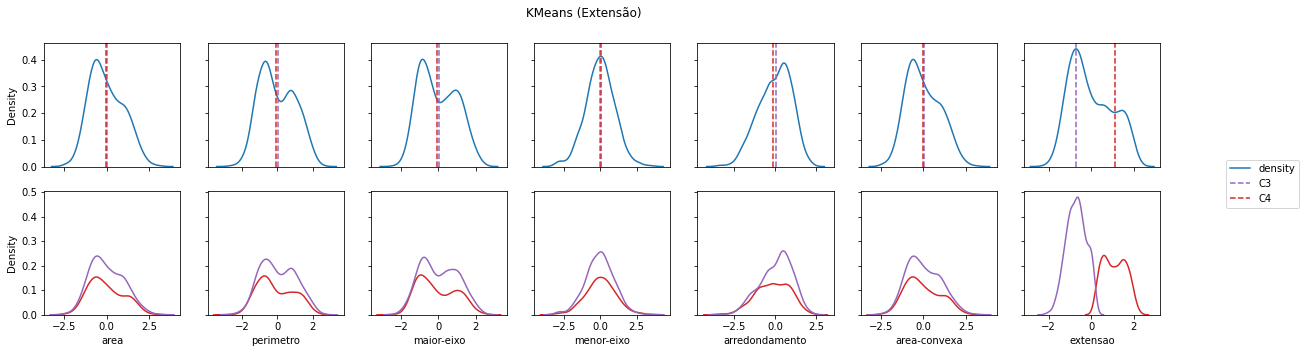

In [206]:
model = KMeans(n_clusters=2)
model.fit(X[["extensao"]])
centroids = NearestCentroid().fit(X, model.labels_).centroids_

fig, ax = plt.subplots(
    nrows=2,
    ncols=len(X.columns),
    sharey="row",
    sharex="col",
    figsize=(20, 5),
)

ignore = []
colors = ["tab:purple", "tab:red"]
for i, col in enumerate(X.columns):
    g = sns.kdeplot(data=X, x=col, ax=ax[0, i], color="tab:blue")
    if col in ignore:
        g.set_title(f"ignorar")
    for k, c in enumerate(centroids):
        g.axvline(x=c[i], linestyle="--", color=colors[k])
fig.legend(
    ["density"] + [f"C{k+3}" for k in range(len(centroids))],
    bbox_to_anchor=(1, 0.57),
)

for i, col in enumerate(X.columns):
    g = sns.kdeplot(
        data=X,
        x=col,
        ax=ax[1, i],
        hue=model.labels_,
        palette=colors[: len(centroids)],
        legend=None,
    )
fig.suptitle("KMeans (Extensão)");

In [207]:
model = next(estimator for estimator in estimators if "KMeans" in str(estimator))[-1]

stats = df.groupby(model.labels_, as_index=False).describe()
for i, col in enumerate(df.columns):
    for s in ["min", "25%", "50%", "75%", "max"] + (["count"] if i > 0 else []):
        stats.drop((col, s), axis=1, inplace=True)
stats

area                  perimetro       maior-eixo      menor-eixo       \
   count     mean     std      mean   std       mean  std       mean  std   
0 643.00 11463.11  906.97    428.19 17.52     175.93 8.44      84.08 5.24   
1 500.00 14362.53 1120.26    490.38 18.77     206.22 9.14      89.76 5.00   

  arredondamento      area-convexa         extensao       
            mean  std         mean     std     mean  std  
0           0.88 0.02     11713.87  929.61     0.67 0.07  
1           0.90 0.01     14699.00 1138.86     0.65 0.08

In [208]:
model = KMeans(n_clusters=2)
model.fit(X[["extensao"]])

stats = df.groupby(model.labels_, as_index=False).describe()
for i, col in enumerate(df.columns):
    for s in ["min", "25%", "50%", "75%", "max"] + (["count"] if i > 0 else []):
        stats.drop((col, s), axis=1, inplace=True)
stats

area                  perimetro       maior-eixo       menor-eixo       \
   count     mean     std      mean   std       mean   std       mean  std   
0 701.00 12773.27 1739.64    457.27 35.35     190.11 17.20      86.44 5.76   
1 442.00 12665.12 1780.05    452.42 36.25     187.71 17.61      86.77 6.00   

  arredondamento      area-convexa         extensao       
            mean  std         mean     std     mean  std  
0           0.89 0.02     13063.28 1783.02     0.61 0.04  
1           0.88 0.02     12950.59 1831.71     0.74 0.04